# NN network for corresponding 

**Motivation:** This scripts aims to model a neural network model with same input parameters as logistic regression model (step, Lasso, ridge)
The architecture is chose as 

In [1]:
final_model_dict = {}

### Load

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## NN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR
import shap

# local
import set_path
import supp.support_load as sl
import supp.support_get_mapping as gm
from supp.support_analyze_model import GraphPlotter, plot_cdf, plot_roc, reliability_plot
from supp.support_save import save_df
from supp.support_model_nn import BinaryClassifier, save_nn_info
from supp.support_model_glm import get_model_coef_df, get_model_coef_dict
from supp.support_model_stats import find_viziers_above_overlap, find_non_viziers_in_overlap, find_viziers_in_overlap, find_persons_in_overlap

#### Load train, validation adn test set

In [3]:
# Load train, validation and test set
data_train = sl.read_csv('df_vizier_train_v1_2')
data_val = sl.read_csv('df_vizier_val_v1_2')
# set 'ID_person' as index
data_train.set_index('ID_person', inplace=True)
data_val.set_index('ID_person', inplace=True)

# Set response
response = 'vizier'
features_all = [col for col in data_train.columns if col != response]

# conver X to numpy
X_train0 = data_train[features_all].to_numpy()
X_val0 = data_val[features_all].to_numpy()
# conver y to numpy
y_train0 = data_train[response].to_numpy()
y_val0 = data_val[response].to_numpy()

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_train_v1_2.csv
CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_val_v1_2.csv


In [4]:
# Check loaded data shape
print(data_train.shape)
print(data_val.shape)

(2684, 44)
(575, 44)


In [5]:
# Check features data shape
print(X_train0.shape)
print(X_val0.shape)

(2684, 43)
(575, 43)


In [6]:
# Check response data shape
print(y_train0.shape)
print(y_val0.shape)

(2684,)
(575,)


In [7]:
# Check count of viziers
print(y_train0.sum())
print(y_val0.sum())

52
11


#### Get feature names from GLM models

In [8]:
# Get dataframe with all GLM coefficients
df_coef = get_model_coef_df()
df_coef

Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\summary_model_coefficients_v0.xlsx


Variable,imy-rA zS(w) a(w) (nw) ncwt,wr 5 (m) pr 9Hwty,HAty-a,zA ncwt n Xt.f,iry-pat,(Intercept),zA ncwt n Xt.f cmcw,imy-rA kAt nbt (nt) ncwt,aD-mr (n) zAb,imy-rA izwy (n) Xkr(w) ncwt,...,Hry-cStA n pr-dwAt,xrp iAwt nbwt nTrwt,r P nb,Xry-Hbt,Hry-cStA,[imAxw xr] nTr aA,imA-a,Htc(?) Inpw,imAxw,imy iz
step_glm,5.9915,3.67680,3.65040,3.57720,2.82940,-6.70740,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lasso_glm,3.7826,3.99760,3.11260,1.58640,2.97140,-7.04420,4.28550,1.70480,1.45760,1.14230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ridge_glm,1.3960,1.43842,1.03702,0.94481,1.13393,-5.20388,1.35576,0.84014,0.32613,0.54447,...,0.23208,0.222,0.16301,0.12225,0.11981,0.07359,0.03907,0.03366,0.03288,0.02262


In [9]:
# Get feature names for each GLM model
coef_step = get_model_coef_dict('step_glm', df=df_coef)
coef_lasso = get_model_coef_dict('lasso_glm', df=df_coef)
coef_ridge = get_model_coef_dict('ridge_glm', df=df_coef)

In [10]:
# Define set of features for each model
omit_features = ['(Intercept)']
features_step = [key for key in coef_step.keys() if key not in omit_features]
features_lasso = [key for key in coef_lasso.keys() if key not in omit_features]
features_ridge = [key for key in coef_ridge.keys() if key not in omit_features]

In [11]:
# Check features len
print(len(features_all))
print(len(features_step))
print(len(features_lasso))
print(len(features_ridge))

43
5
13
36


In [12]:
print(list(coef_step.keys()))
print(list(coef_lasso.keys()))
print(list(coef_ridge.keys()))

['imy-rA zS(w) a(w) (nw) ncwt', 'wr 5 (m) pr 9Hwty', 'HAty-a', 'zA ncwt n Xt.f', 'iry-pat', '(Intercept)']
['imy-rA zS(w) a(w) (nw) ncwt', 'wr 5 (m) pr 9Hwty', 'HAty-a', 'zA ncwt n Xt.f', 'iry-pat', '(Intercept)', 'zA ncwt n Xt.f cmcw', 'imy-rA kAt nbt (nt) ncwt', 'aD-mr (n) zAb', 'imy-rA izwy (n) Xkr(w) ncwt', 'imy-rA Snwty', 'imy-rA prwy-HD', 'Hry-cStA n wD(t)-mdw nbt nt ncwt', 'Xry-Hbt Hry-tp']
['imy-rA zS(w) a(w) (nw) ncwt', 'wr 5 (m) pr 9Hwty', 'HAty-a', 'zA ncwt n Xt.f', 'iry-pat', '(Intercept)', 'zA ncwt n Xt.f cmcw', 'imy-rA kAt nbt (nt) ncwt', 'aD-mr (n) zAb', 'imy-rA izwy (n) Xkr(w) ncwt', 'imy-rA Snwty', 'imy-rA prwy-HD', 'Hry-cStA n wD(t)-mdw nbt nt ncwt', 'Xry-Hbt Hry-tp', 'xtm(ty)-bity', 'imy-rA 5maw', 'imy-rA gc-pr', 'imy iz Nxn', 'xrp SnDt nbt', 'zA ncwt', 'zS mDAt-nTr', 'aA 8wAw', 'Xry-tp ncwt', 'imy-rA prwy-nbw', 'imAxw xr Wcir', 'xrp aH', 'cmr waty', 'Hry-cStA n pr-dwAt', 'xrp iAwt nbwt nTrwt', 'r P nb', 'Xry-Hbt', 'Hry-cStA', '[imAxw xr] nTr aA', 'imA-a', 'Htc(?) In

In [13]:
# this title was removed in GLM because of high VIF
set(features_all) - set(features_ridge)

{'Hry-tp Nxb',
 'cm / ctm',
 'cmcw cnwt',
 'imy-rA wabty',
 'iwn knmwt',
 'mdw rxyt',
 'mniw Nxn / zAw Nxn'}

### Train function

In [14]:
# define hidden_size
# (can be overwriten later)
hidden_size = [2]

In [15]:
# Define the weight of positive examples
sum_vizier = y_train0.sum() 
sum_non_vizier = y_train0.shape[0] - sum_vizier
pos_weight = sum_non_vizier / sum_vizier
pos_weight = 1
pos_weight = torch.tensor([pos_weight], dtype=torch.float32)
# Set criterion
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Using BCEWithLogitsLoss

pos_weight

tensor([1.])

In [35]:
def train_nn(params):
    """
    This funtion serves as main method for training NN model
        - defines model
        - defines optimizer
        - carry the training process
        - choose the best model via early stopping
        - calc train and vall loss
        - plot evolution of loss
        - saves final model
        
    Parameters:
        params (dict): hyperparameters of the NN model
    """
    print(f'===================================')
    print(f' S T A R T I N G   M O D E L')
    print(f'===================================\n')
    current_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Set params
    typ = params['typ']
    batch_size = params['batch_size']
    hidden_size = params['hidden_size']
    activation_name = params['activation_name']
    dropout_prob = params['dropout_prob']
    optimizer_name = params['optimizer_name']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    patience = params['patience']
    weight_decay_value = params['l2_lambda']

    # Set features space
    features = {'step': features_step,
                'lasso': features_lasso,
                'ridge': features_ridge
               }[typ]
    X_train = data_train[features].to_numpy()
    X_val = data_val[features].to_numpy()
    
    # Converting data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_train = torch.tensor(y_train0, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(y_val0, dtype=torch.float32).unsqueeze(1)
    
    # Prepare datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    input_size = X_train.shape[1]
    # Define model, loss function and optimizer
    model = BinaryClassifier(input_size, hidden_size, activation_name, dropout_prob=dropout_prob)
    
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == "nadam":
        optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
    print(f'Defined BinaryClassifier with {criterion=}')
    print(f'Defined BinaryClassifier with {optimizer=}')

    # Print model architecture
    print(f'\n===================================')
    print(f'MODEL ARCHITECTURE:\n{model}')
    print(f'===================================\n')
    
    # Declare losses
    train_losses = []
    val_losses = []
    pio_list = []     # persons in overlap
    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0

    # Flag for learning rate reduce
    lr_reduced_1 = False 
    lr_reduced_2 = False 
    # Train the model
    for epoch in range(epochs):

        # Training step
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        # Compute average train loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        y_true = []
        y_hat = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                # Get y_true and y_hat batch
                y_true.extend([el.item() for el in batch_y])
                probabilities = torch.sigmoid(outputs)
                y_hat.extend([el.item() for el in probabilities])
        # Compute average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        # Compute persons in overlap
        col = 'probs'
        df_probs= pd.DataFrame({'vizier': y_true, col: y_hat})
        pio = find_persons_in_overlap(df_probs, col)
        pio_list.append(pio)
    
        # Print current epoch performance
        print(
            f"Epoch {epoch+1}/{epochs},\t"
            f"Train Loss: {train_loss:.4f},\t"
            f"Validation Loss: {val_loss:.4f},\t"
            #f"LR: {scheduler.get_last_lr()[0]:.6f}"
        )
    
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), rf'nn_models\best_mlp_{typ}_v1.pth')
        else:
            patience_counter += 1
            print(f"\tEarly stopping patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("\tEarly stopping triggered. Stopping training.")
                break
        
        # Update learing rate
        if val_loss < 0.02 and not lr_reduced_1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / 5
            print(f"Learning rate reduced to: {param_group['lr']}")
            lr_reduced_1 = True
        # # if val_loss < 0.061 and not lr_reduced_2:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = param_group['lr'] / 10
        #     print(f"Learning rate reduced to: {param_group['lr']}")
        #     lr_reduced_2 = True

        # Update learing rate
        #scheduler.step()
    
    # Load the best model after early stopping
    model.load_state_dict(torch.load(rf'nn_models\best_mlp_{typ}_v1.pth'))
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()
    # Plot evolutio of persons in overlap
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(val_losses)+1), pio_list, label='Persons in overlap')
    plt.xlabel('Epochs')
    plt.ylabel('Persons in overlap')
    plt.title('Evolution of Persons in Overlap')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Save the model
    path_save = rf'nn_models\mlp_{typ}_{current_time}.pth'
    torch.save(model.state_dict(), path_save)
    save_nn_info(input_size, hidden_size, activation_name, features, path_save)


    # print model lacation
    print(f'\n\n===================================')
    print(f' M O D E L   L O C A T I O N :')
    print(f'{path_save}')
    print(f'===================================\n')
    final_model_dict[typ] = path_save

    # print model lacation
    print(f'\n\n===================================')
    print(f' persons_in_overlap: {pio_list[-1]}')
    print(f'===================================\n')

    model.eval()
    return model, val_loader

In [17]:
def plot_shaps(model, features_set, output_path=None):
    # Prepare data
    X_df = data_train[features_set]
    X_df = X_df.sample(frac=1, random_state=42).reset_index(drop=True)
    X_explain = torch.tensor(X_df.values, dtype=torch.float32)
    X_sample = X_explain[:150]
    
    # Choose Explainer
    model.eval()
    explainer = shap.GradientExplainer(model, X_sample)
    # Calculate SHAP values
    shap_values_step = explainer.shap_values(X_explain)
    # Remove the last dimension
    shap_values_step = shap_values_step.squeeze(-1)
    
    # Plot and save SHAP 
    plt.figure()
    shap.summary_plot(shap_values_step, X_explain.numpy(), feature_names=features_set, show=False)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(f'{output_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{output_path}.pdf', bbox_inches='tight')
    plt.show()

In [18]:
def print_stats(model, val_loader, params):
    # Validation step
    model.eval()
    val_loss = 0.0
    y_true = []
    y_hat = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            # Get y_true and y_hat batch
            y_true.extend([el.item() for el in batch_y])
            probabilities = torch.sigmoid(outputs)
            y_hat.extend([el.item() for el in probabilities])
    # Compute average validation loss
    val_loss /= len(val_loader.dataset)
    # Compute persons in overlap
    col = 'probs'
    df_probs= pd.DataFrame({'vizier': y_true, col: y_hat})
    pio_val = find_persons_in_overlap(df_probs, col)
    mean_vizier = df_probs.loc[df_probs['vizier']==1, col].mean()
    mean_non_vizier = df_probs.loc[df_probs['vizier']==0, col].mean()
    bottom_3_vizier = df_probs.loc[df_probs['vizier']==1, col].sort_values().to_list()[3]
    top_3_non_vizier = df_probs.loc[df_probs['vizier']==0, col].sort_values().to_list()[-3]
    
    print(params)
    print(f"Validation Loss:\t{val_loss:.4f}")
    print(f"Mean vizier:\t\t{mean_vizier:.4f}")
    print(f"Mean non-vizier:\t{mean_non_vizier:.4f}")
    print(f"bottom_3_vizier:\t{bottom_3_vizier:.4f}")
    print(f"top_3_non_vizier:\t{top_3_non_vizier:.4f}")
    print(f"PiO Validation:\t\t{pio_val}")

### Step NN

 S T A R T I N G   M O D E L

Defined BinaryClassifier with criterion=BCEWithLogitsLoss()
Defined BinaryClassifier with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

MODEL ARCHITECTURE:
BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
  )
)

Epoch 1/1000,	Train Loss: 0.6885,	Validation Loss: 0.6668,	
Epoch 2/1000,	Train Loss: 0.6598,	Validation Loss: 0.6389,	
Epoch 3/1000,	Train Loss: 0.6322,	Validation Loss: 0.6120,	
Epoch 4/1000,	Train Loss: 0.6057,	Validation Loss: 0.5862,	
Epoch 5/1000,	Train Loss: 0.5803,	Validation Loss: 0.5615,	
Epoch 6/1000,	Train Loss: 0.5561,	Validation Loss: 0.5379,	
Epoch 7/1000,	Train Loss: 0.5329,	Validation Loss: 0.5155,	
Epoch 8/1000,	Train Loss: 0.5108,	Validation Loss: 0.4941,	
Epoch 9/1000,	Train Loss: 0.4899,	Validatio

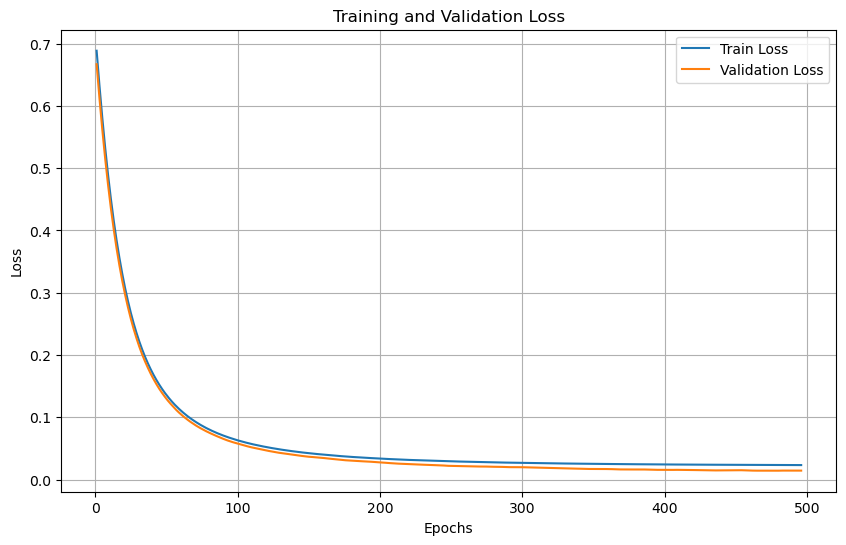

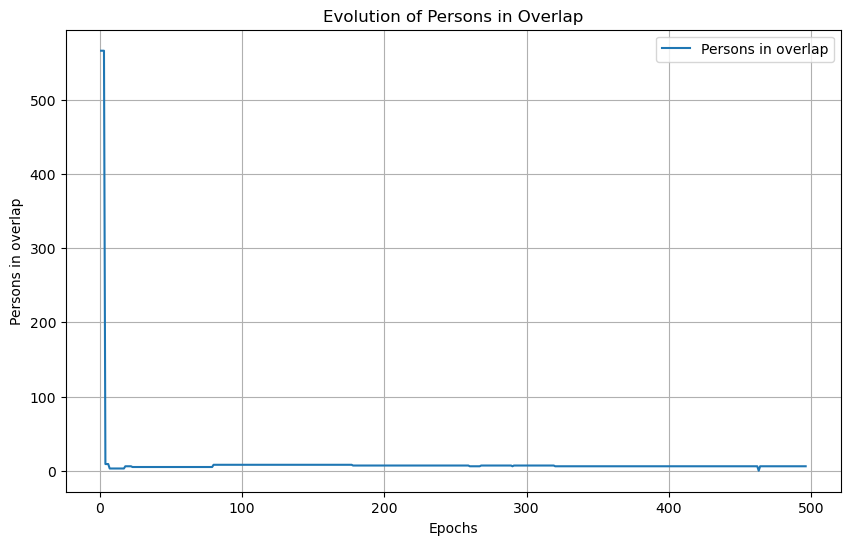



 M O D E L   L O C A T I O N :
nn_models\mlp_step_2025-05-02-23-22-53.pth



 persons_in_overlap: 6



In [19]:
params = {'typ': 'step',
          'batch_size': 512,
          'hidden_size': [],
          'dropout_prob': 0,
          'activation_name': 'relu',
          'optimizer_name': 'adam',
          'epochs': 1000,
          'learning_rate': 0.01,
          'patience': 20,
          'l2_lambda': 0
         }
model_step, val_loader_step = train_nn(params)

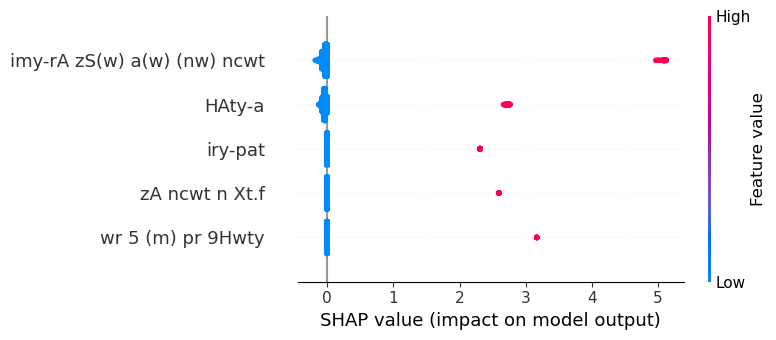

In [20]:
plot_shaps(model_step, features_step)

In [21]:
print_stats(model_step, val_loader_step, params)

{'typ': 'step', 'batch_size': 512, 'hidden_size': [], 'dropout_prob': 0, 'activation_name': 'relu', 'optimizer_name': 'adam', 'epochs': 1000, 'learning_rate': 0.01, 'patience': 20, 'l2_lambda': 0}
Validation Loss:	0.0144
Mean vizier:		0.7585
Mean non-vizier:	0.0069
bottom_3_vizier:	0.4526
top_3_non_vizier:	0.3944
PiO Validation:		6


### Lasso NN

 S T A R T I N G   M O D E L

Defined BinaryClassifier with criterion=BCEWithLogitsLoss()
Defined BinaryClassifier with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

MODEL ARCHITECTURE:
BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=1, bias=True)
  )
)

Epoch 1/1000,	Train Loss: 0.6885,	Validation Loss: 0.6668,	
Epoch 2/1000,	Train Loss: 0.6590,	Validation Loss: 0.6386,	
Epoch 3/1000,	Train Loss: 0.6309,	Validation Loss: 0.6115,	
Epoch 4/1000,	Train Loss: 0.6039,	Validation Loss: 0.5855,	
Epoch 5/1000,	Train Loss: 0.5780,	Validation Loss: 0.5606,	
Epoch 6/1000,	Train Loss: 0.5533,	Validation Loss: 0.5368,	
Epoch 7/1000,	Train Loss: 0.5299,	Validation Loss: 0.5142,	
Epoch 8/1000,	Train Loss: 0.5076,	Validation Loss: 0.4927,	
Epoch 9/1000,	Train Loss: 0.4864,	Validati

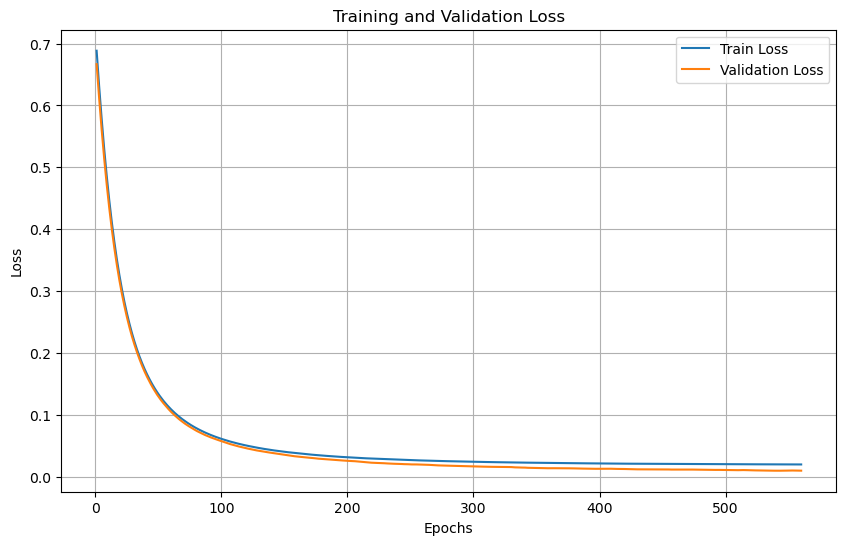

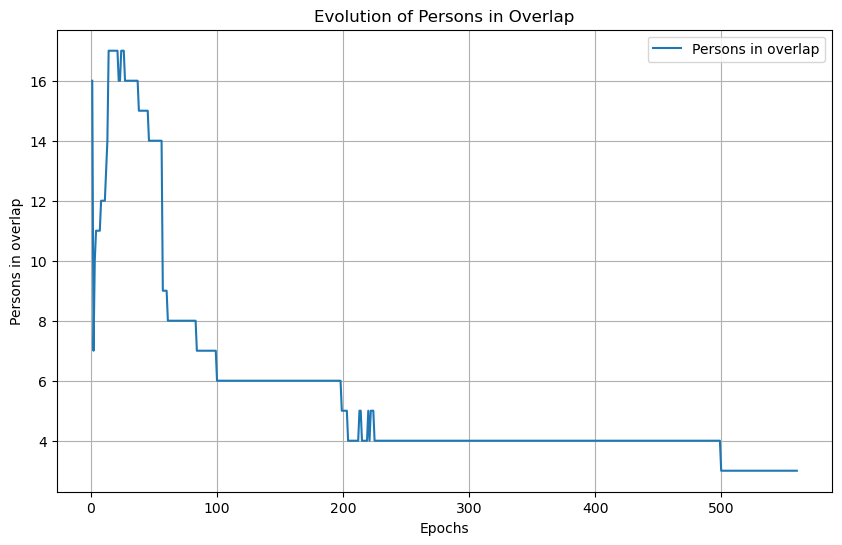



 M O D E L   L O C A T I O N :
nn_models\mlp_lasso_2025-05-02-23-23-55.pth



 persons_in_overlap: 3



In [22]:
params = {'typ': 'lasso',
          'batch_size': 512,
          'hidden_size': [],
          'dropout_prob': 0,
          'activation_name': 'relu',
          'optimizer_name': 'adam',
          'epochs': 1000,
          'learning_rate': 0.01,
          'patience': 20,
          'l2_lambda': 0
         }
model_lasso, val_loader_lasso = train_nn(params)

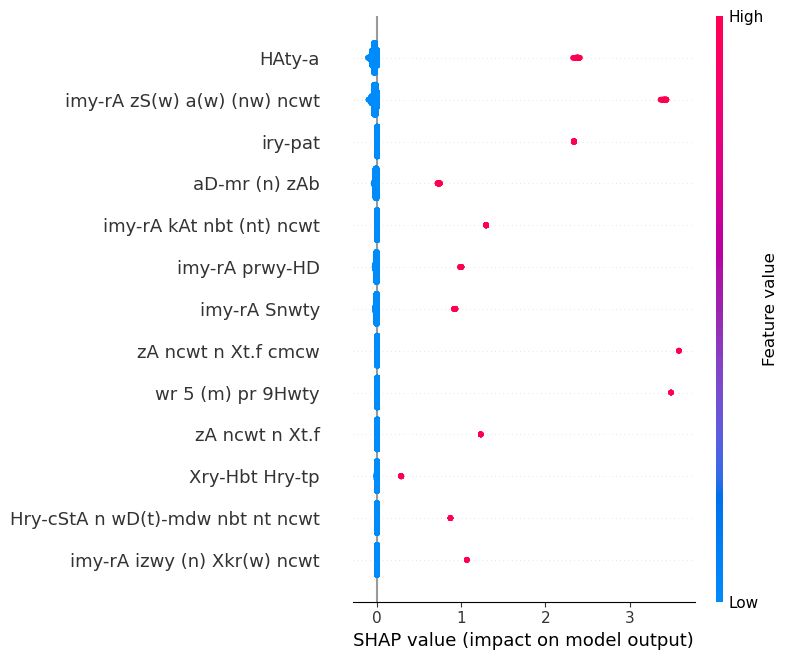

In [23]:
output_path = rf'img/shap_summary_plot/model_lasso_dropout_{params["dropout_prob"]}'
plot_shaps(model_lasso, features_lasso, output_path=output_path)

In [24]:
print_stats(model_lasso, val_loader_lasso, params)

{'typ': 'lasso', 'batch_size': 512, 'hidden_size': [], 'dropout_prob': 0, 'activation_name': 'relu', 'optimizer_name': 'adam', 'epochs': 1000, 'learning_rate': 0.01, 'patience': 20, 'l2_lambda': 0}
Validation Loss:	0.0097
Mean vizier:		0.8458
Mean non-vizier:	0.0050
bottom_3_vizier:	0.8982
top_3_non_vizier:	0.2485
PiO Validation:		3


### Ridge NN

 S T A R T I N G   M O D E L

Defined BinaryClassifier with criterion=BCEWithLogitsLoss()
Defined BinaryClassifier with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)

MODEL ARCHITECTURE:
BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=36, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

Epoch 1/1000,	Train Loss: 0.6840,	Validation Loss: 0.6720,	
Epoch 2/1000,	Train Loss: 0.6649,	Validation Loss: 0.6531,	
Epoch 3/1000,	Train Loss: 0.6453,	Validation Loss: 0.6323,	
Epoch 4/1000,	Train Loss: 0.6226,	Validation Loss: 0.6088,	
Epoch 5/1000,	Train Loss: 0.5979,	Validation Loss: 0.

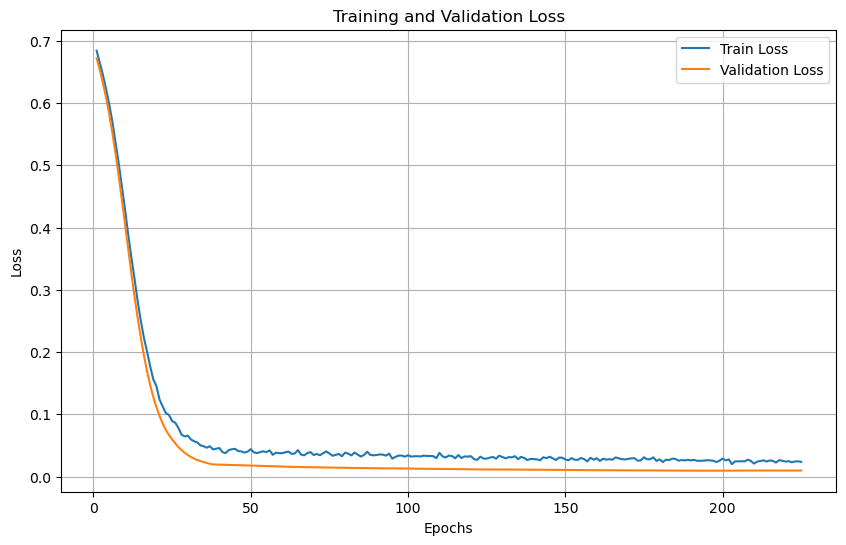

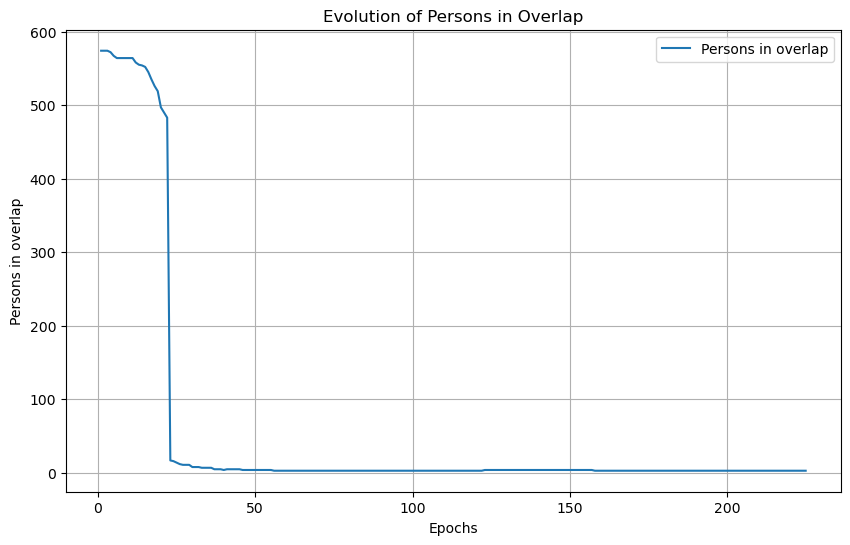



 M O D E L   L O C A T I O N :
nn_models\mlp_ridge_2025-05-03-00-52-36.pth



 persons_in_overlap: 3



In [217]:
params = {'typ': 'ridge',
          'batch_size': 512,
          'hidden_size': [16,4],
          'dropout_prob': 0.2,
          'activation_name': 'relu',
          'optimizer_name': 'adam',
          'epochs': 1000,
          'learning_rate': 0.002,
          'patience': 20,
          'l2_lambda': 0
         }
model_ridge, val_loader_ridge = train_nn(params)

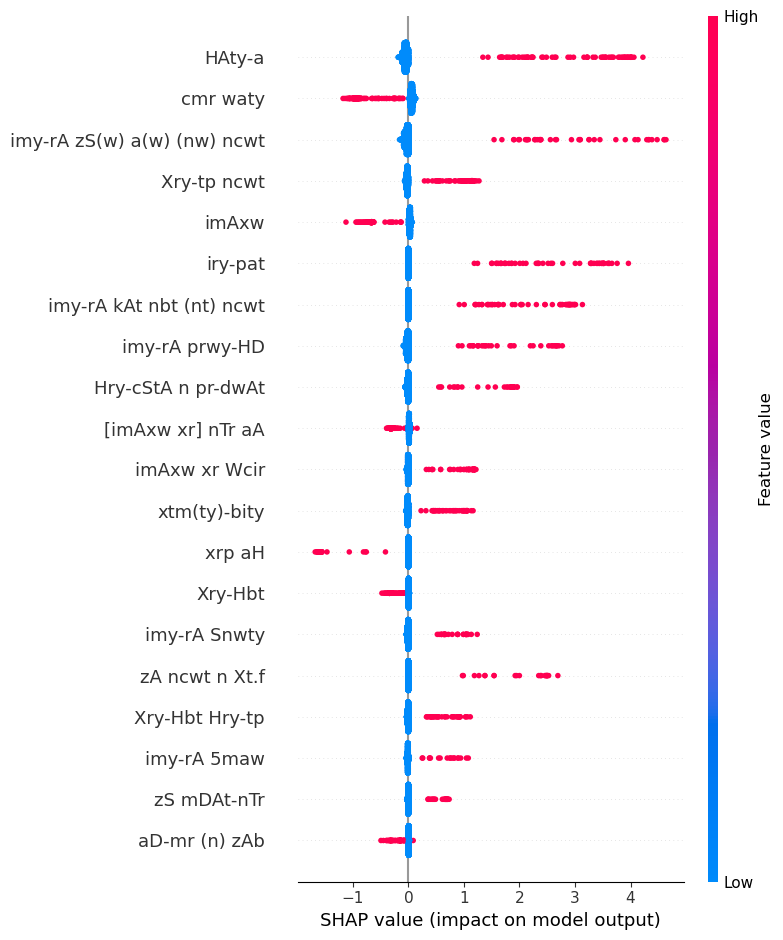

In [218]:
plot_shaps(model_ridge, features_ridge)

In [215]:
print_stats(model_ridge, val_loader_ridge, params)

{'typ': 'ridge', 'batch_size': 512, 'hidden_size': [16, 4], 'dropout_prob': 0.5, 'activation_name': 'relu', 'optimizer_name': 'adam', 'epochs': 1000, 'learning_rate': 0.002, 'patience': 20, 'l2_lambda': 0}
Validation Loss:	0.0123
Mean vizier:		0.6882
Mean non-vizier:	0.0034
bottom_3_vizier:	0.6994
top_3_non_vizier:	0.1734
PiO Validation:		3


### Models summary

In [28]:
# print final_model_list
final_model_dict

{'step': 'nn_models\\mlp_step_2025-05-02-23-22-53.pth',
 'lasso': 'nn_models\\mlp_lasso_2025-05-02-23-23-55.pth',
 'ridge': 'nn_models\\mlp_ridge_2025-05-02-23-25-00.pth'}